## Reproduction code for the noiseless-data setting

This notebook contains the code for reproducing the numerical results under the noiseless-data setting in the paper *Simultaneous activity and attenuation estimation
in TOF-PET with TV-constrained nonconvex
optimization*. In specific, the code in this notebook reproduces Figure 1-4 of the paper.


We start from loading the libraries necessary for running the code.

In [14]:
from numpy import *
import numpy as np
svd = linalg.svd
randn = random.randn
import numba
from numba import njit
from pylab import *
ion()
import scipy
from scipy import ndimage

Load the test images stored under the directory `"./data/"`. Here, `testmu` is the ground-truth attenuation map and `testlambda` is the ground-truth activity map. We plot the two ground-truth maps, reproducing Figure 1.

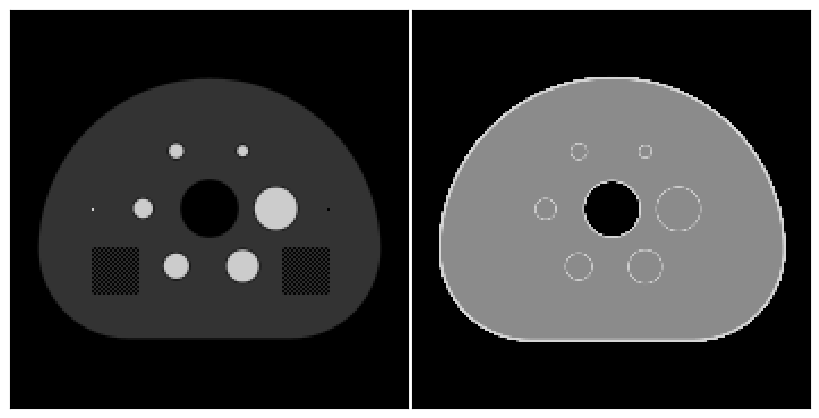

In [15]:
# Load the test images
testmu = load("./data/UWDRO1_slice40_attenuation.npy")[40:216,40:216]*1.
testlambda = load("./data/UWDRO1_slice40_activity.npy")[40:216,40:216]*1.


# Plot the ground-truth maps
gf = ndimage.gaussian_filter
vmm1= 0.0
vmx1= 40000
vmm2= 0.075
vmx2= 0.115
figure(1,figsize=(8,4))
subplot(121)
imshow(testlambda,vmin = vmm1, vmax = vmx1, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplot(122)
imshow(testmu,vmin = vmm2, vmax = vmx2, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplots_adjust(left = 0, bottom = 0,top = 1,right= 1,wspace =0.01)

Both the activity map and the attenuation map are of size $30\times30$ $\text{cm}^2$, and are discretized  into $176\times 176$ pixels. The activity map is normalized such that the expected total number of counts is $4.0\times 10^6$. There are $176\times 176$ pairs of detectors in the system, where the lines-of-response (LORs) are organized in parallel-ray fashion; the distance between a pair of two detectors is $200$ cm. The TOF window sensitivity along the LOR is specified by $$w_i(t) = \exp(-(t-t_i)^2/(2\sigma_{\text{TOF}})).$$ The full-width-half-maximum (FWHM) is $2\sqrt{2\log 2}\sigma_{\text{TOF}}$, and is taken to be $4.5$ cm in our simulation.

In [16]:
mumask = testmu*0.
mumask[testmu>0.]=1.
totalcounts = 4.0e6 
nx = 176
ny = 176
ximageside = 30.0   
yimageside = 30.0   
dx = ximageside/nx
dy = yimageside/ny
xar=arange(-ximageside/2. + dx/2 , ximageside/2., dx)[:,newaxis]*ones([nx])
yar=ones([nx,ny])*arange(-yimageside/2. + dy/2 , yimageside/2., dy)
rar=sqrt(xar**2 + yar**2)
fovmask = testlambda*0.
lambdamask = fovmask*0.
smallmask = testlambda*0.
fovmask[rar<=ximageside/2.] = 1.
lambdamask[rar<=ximageside/4.5] = 1.
smallmask[sqrt((xar-0.)**2 + (yar-5.)**2)<=ximageside/20.] = 1.
mumask = fovmask*1.
flatmask = fovmask.flatten()*1.


radius = 100.0    #cm
detector1_to_detector2 = 200.0   #cm
nviews = 176
slen = pi     
nbins = 176
# The linear detector length is computed in the projection function so that it is
# the exact size needed to capture the projection of the largest inscribed circle in
# the image array.

dtc = dx/16.
ntc = int(detector1_to_detector2/dtc)
tcshift = 0.5*(detector1_to_detector2 - ntc*dtc)
war = arange(radius-detector1_to_detector2+tcshift,radius,dtc)

fwhm = 4.5 #cm

tofspacing = fwhm/2.
toflen = ximageside+2*fwhm
toflen = minimum(toflen,detector1_to_detector2)
tofsig= fwhm/2.355
dtof = tofspacing
ntof = int(toflen/dtof)
toflen = ntof*dtof    #change the toflen so that it is a multiple of dtof
tof0 = -toflen/2.
tofmat = []
for i in range(ntof):
   w0 = (i+0.5)*dtof + tof0
   wfun = exp( -((war-w0)**2)/(2.*tofsig**2))
   tofmat.append(wfun)
tofmat = array(tofmat)



TOF res. is:  300.2076856783369  picoseconds.
toflen:  38.25  ntof:  17


The following code contains utility functions essential for running the code.

In [17]:
## function for forward projection

@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
def circularParallelBeamProjection(wimage,sinogram, mask = mumask,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   sinogram.fill(0.)
   image = mask*wimage
   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            raysum=0.
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     raysum=raysum+travPixlen*image[ix,iy]
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     raysum = raysum+frac1*travPixlen*image[ix,iyOld]
                  if ((iy>=0) and (iy<ny)):
                     raysum=raysum+frac2*travPixlen*image[ix,iy]
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            raysum=0.
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     raysum=raysum+travPixlen*image[ix,iy]
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     raysum=raysum+frac1*travPixlen*image[ixOld,iy]
                  if ((ix>=0) and (ix<nx)) :
                     raysum=raysum+frac2*travPixlen*image[ix,iy]
               ixOld=ix
               xIntOld=xIntercept
         sinogram[sindex,uindex]=raysum

## function for backward projection
@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
def circularParallelBeamBackProjection(sinogram, image, mask = mumask,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   image.fill(0.)

   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):
         sinoval = sinogram[sindex,uindex]

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     image[ix,iyOld] =image[ix,iyOld]+frac1*sinoval*travPixlen
                  if ((iy>=0) and (iy<ny)):
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     image[ixOld,iy] =image[ixOld,iy]+frac1*sinoval*travPixlen
                  if ((ix>=0) and (ix<nx)) :
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen
               ixOld=ix
               xIntOld=xIntercept
   image *= mask


## function for weighted forward projection
@njit(cache=True) # if computing projection multiple times use: @njit(cache=true)
def circularParallelBeamWProjection(image,sinogram, weighting, dtc = dtc, tcshift = tcshift,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   sinogram.fill(0.)
   
   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.


   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensues ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            raysum=0.
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               ymid = yl+dy*(iyOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     raysum=raysum+tofweight1*travPixlen*image[ix,iy]
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     raysum = raysum+tofweight2*frac1*travPixlen*image[ix,iyOld]
                  if ((iy>=0) and (iy<ny)):
                     raysum=raysum+tofweight1*frac2*travPixlen*image[ix,iy]
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            raysum=0.
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               xmid = xl+dx*(ixOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     raysum=raysum+tofweight1*travPixlen*image[ix,iy]
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     raysum=raysum+tofweight2*frac1*travPixlen*image[ixOld,iy]
                  if ((ix>=0) and (ix<nx)) :
                     raysum=raysum+tofweight1*frac2*travPixlen*image[ix,iy]
               ixOld=ix
               xIntOld=xIntercept
         sinogram[sindex,uindex]=raysum

## function for weighted backward projection

@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
def circularParallelBeamWBackProjection(sinogram, image, weighting, dtc = dtc, tcshift = tcshift,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   image.fill(0.)

   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):
         sinoval = sinogram[sindex,uindex]

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               ymid = yl+dy*(iyOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen*tofweight1
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     image[ix,iyOld] =image[ix,iyOld]+frac1*sinoval*travPixlen*tofweight2
                  if ((iy>=0) and (iy<ny)):
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen*tofweight1
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               xmid = xl+dx*(ixOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen*tofweight1
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     image[ixOld,iy] =image[ixOld,iy]+frac1*sinoval*travPixlen*tofweight2
                  if ((ix>=0) and (ix<nx)) :
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen*tofweight1
               ixOld=ix
               xIntOld=xIntercept


## functions for time-of-flight projection matrix multiplication

def TOFprojection(wimage,tofsino,mask=fovmask,tofmat=tofmat,ntof=ntof,nviews=nviews,nbins=nbins):
   tofsino.fill(0.)
   image = mask*wimage
   for i in range(ntof):
      circularParallelBeamWProjection(image,tofsino[i],tofmat[i])


def TOFbackProjection(tofsino,image,mask=fovmask,tofmat=tofmat,ntof=ntof,nviews=nviews,nbins=nbins):
   image.fill(0.)
   wim = image*0.
   for i in range(ntof):
      circularParallelBeamWBackProjection(tofsino[i],wim,tofmat[i])
      image += wim
   image *= mask

## utility functions for saatv-admm

#gradient implementations for TV
def gradim(image):

   xgrad = image.copy()
   ygrad = image.copy()
   temp = image
   xgrad[:-1,:] = temp[1:,:] - temp[:-1,:]
   ygrad[:,:-1] = temp[:,1:] - temp[:,:-1]
   xgrad[-1,:] =  -1.0* temp[-1,:]
   ygrad[:,-1] =  -1.0* temp[:,-1]

   return xgrad,ygrad


def mdiv(xgrad,ygrad):
   divim = xgrad.copy()
   shp = [xgrad.shape[0] + 2, xgrad.shape[1] +2]
   xgradp=zeros(shp)
   ygradp=zeros(shp)
   xgradp[1:-1,1:-1] = xgrad*1.
   ygradp[1:-1,1:-1] = ygrad*1.
   divim.fill(0.)
   divim = xgradp[:-2,1:-1] + ygradp[1:-1,:-2] - xgradp[1:-1,1:-1] - ygradp[1:-1,1:-1]

   return divim


def euclidean_proj_simplex(v, s=1):
   """ Compute the Euclidean projection on a positive simplex

    Solves the optimisation problem (using the algorithm from [1]):

        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0 

    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project

    s: int, optional, default: 1,
       radius of the simplex

    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the simplex

    Notes
    -----
    The complexity of this algorithm is in O(n log(n)) as it involves sorting v.
    Better alternatives exist for high-dimensional sparse vectors (cf. [1])
    However, this implementation still easily scales to millions of dimensions.

    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
   assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
   n, = v.shape  # will raise ValueError if v is not 1-D
   # check if we are already on the simplex
   if v.sum() == s and np.alltrue(v >= 0):
      # best projection: itself!
      return v
   # get the array of cumulative sums of a sorted (decreasing) copy of v
   u = np.sort(v)[::-1]
   cssv = np.cumsum(u)
   # get the number of > 0 components of the optimal solution
   rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
   # compute the Lagrange multiplier associated to the simplex constraint
   theta = (cssv[rho] - s) / (rho + 1.0)
   # compute the projection by thresholding v using theta
   w = (v - theta).clip(min=0)
   return w


def euclidean_proj_l1ball(v, s=1):
   """ Compute the Euclidean projection on a L1-ball

    Solves the optimisation problem (using the algorithm from [1]):

        min_w 0.5 * || w - v ||_2^2 , s.t. || w ||_1 <= s
   Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project

    s: int, optional, default: 1,
       radius of the L1-ball

    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the L1-ball of radius s

    Notes
    -----
    Solves the problem by a reduction to the positive simplex case

    See also
    --------
    euclidean_proj_simplex
    """
   assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
   n, = v.shape  # will raise ValueError if v is not 1-D
   # compute the vector of absolute values
   u = np.abs(v)
   # check if v is already a solution
   if u.sum() <= s:
       # L1-norm is <= s
       return v
   # v is not already a solution: optimum lies on the boundary (norm == s)
   # project *u* on the simplex
   w = euclidean_proj_simplex(u, s=s)
   # compute the solution to the original problem on v
   w *= np.sign(v)
   return w




In this noiseless-data setting, the count data for TOF-window $i$ and LOR $\ell$ is specified as 
$$
C_{i\ell} = \exp(-P_i^\top \mu) \cdot T_{t\ell}^\top \lambda.
$$
The count data is rescaled such that $\sum_{i,\ell}C_{i\ell} = 1.0\times 10^6$.


In [53]:

tvmuswitch = 1
tvlamswitch = 1
sinogram=zeros([nviews,nbins],"float64")
sinoatt = sinogram.copy()
sinoatt.fill(0.)
circularParallelBeamProjection(testmu,sinoatt)
attfactor = exp(-sinoatt)
tofsino = zeros([ntof,nviews,nbins])
TOFprojection(testlambda,tofsino)
truess = tofsino.sum(axis=0)
tofdata = attfactor*tofsino
datafactor = totalcounts/tofdata.sum() #scale the data to the desired count level
tofdata *= datafactor
tofsino *= datafactor
testlambda  *= datafactor
truess *= datafactor
ltotalcounts = testlambda.sum()

# normalize again (need to do it this way to allow control over noise)
scalefactor = 1.   #This scalefactor shows how to adjust step sizes so that performance is the same wrt scaling
newfactor = scalefactor*(fovmask.sum()/tofdata.sum())
tofdata *= newfactor
tofsino *= newfactor
testlambda  *= newfactor
truess *= newfactor
ltotalcounts *= newfactor

To implement ADMM-TVSAA, we need to compute the largest singular values of $T$ and $P$, i.e., $\|T\|_2$ and $\|P\|_2$. We shall also compute the constraints on the TV-norm of the attenuation map $\mu$ and the activity map $\lambda$, i.e., $\|\mu\|_{\text{TV}}$ and $\|\lambda\|_{\text{TV}}$.

In [54]:
ltofproj,lproj,numu,nulam,ltotmu,ltotlam = np.load("data/stepdata4p5_nulam0p5.npy")
ptvmu = 100
tgx,tgy = gradim(testmu)
tvmu = numu*sqrt(tgx**2 + tgy**2).sum() *(1.*ptvmu/100.0)
ptvlam = 100
tgx,tgy = gradim(testlambda)
tvlambda = nulam*sqrt(tgx**2 + tgy**2).sum() *(1.*ptvlam/100.0)
ltotalcounts = testlambda.sum()

For each algorithm, we set the number of outer loops to be 5001. 
For ADMM-TVSAA, the number of alternating optimization steps is set to be 100, and the 
number of Newton steps is 10.

In [20]:
niter = 5001 # number of outer loops
newtiter = 10 # number of newton steps
nuv = 100 # number of alternating optimization steps

In [21]:
# output directory
resultsfile = './results/saa_bothTV_'

# parameters 
tvlamswitch = 1
tvmuswitch = 1
sbmu = 0.2*scalefactor 
sblambda = 4.0/scalefactor
sigmu = sbmu/lproj
taumu = 1.0/(sbmu*lproj)
siglambda = sblambda/ltofproj
taulambda = 1.0/(sblambda*ltofproj)

# initialization
worktofsino = 0.*tofsino
ulambda = 0.*tofsino
ylambda = 0.*tofsino

imlambda = testlambda*0.
wimlambda = testlambda*0.
ugradlamx = testlambda*0.
ygradlamx = testlambda*0.
ugradlamy = testlambda*0.
ygradlamy = testlambda*0.

worksino = 0.*sinoatt
umu = 0.*sinoatt
ymu = 0.*sinoatt
ugradmux = testlambda*0.
ygradmux = testlambda*0.
ugradmuy = testlambda*0.
ygradmuy = testlambda*0.

immu = testmu*0.
wimmu = testmu*0.

datarmses = []
imagelrmses = []
imagemrmses = []
atttv = []
acttv=[]
attrmses = []
storeiterations=[1,2,5,10,20,50,100,200,500,1000,5000]

# run saa-admm
for j in range(niter):
# x-update
   TOFprojection(imlambda,worktofsino)
   arg1 = ulambda+siglambda*(worktofsino -ylambda)
   TOFbackProjection(arg1,wimlambda)
   tgx,tgy = gradim(imlambda)
   tgx *= nulam
   tgy *= nulam

   argx = ugradlamx + siglambda*(tgx - ygradlamx)
   argy = ugradlamy + siglambda*(tgy - ygradlamy)
   wgradimlam = mdiv(argx,argy)
   wgradimlam *= nulam*fovmask
   tvlamest  = sqrt(tgx**2 + tgy**2).sum()

   tempvex =(imlambda -taulambda*(wimlambda +wgradimlam )).flatten()
   tempvex2 = tempvex[flatmask>0.5]
   resvex = euclidean_proj_simplex(tempvex2, s=ltotalcounts)
   tempvex[flatmask>0.5] = resvex*1.
   tempvex.shape = nx,ny
   imlambda = tempvex*1.


   TOFprojection(imlambda,worktofsino)
   workgradlamx, workgradlamy = gradim(imlambda)
   workgradlamx *= nulam
   workgradlamy *= nulam


   circularParallelBeamProjection(immu,worksino)
   arg1 = umu +sigmu*( worksino -ymu )
   circularParallelBeamBackProjection(arg1,wimmu)
   tgx,tgy = gradim(immu)
   tgx *= numu
   tgy *= numu
   argx = ugradmux + sigmu*(tgx - ygradmux)
   argy = ugradmuy + sigmu*(tgy - ygradmuy)
   wgradimmu = mdiv(argx,argy)
   wgradimmu *= numu*fovmask
   immu =immu - wimmu*taumu - wgradimmu*taumu
   immu[immu<0.]=0.
   immu *= mumask


   circularParallelBeamProjection(immu,worksino)
   workgradmux, workgradmuy = gradim(immu)
   workgradmux *= numu
   workgradmuy *= numu

   tvmuest  = sqrt(tgx**2 + tgy**2).sum()
   acttv.append(tvlamest/tvlambda)
   atttv.append(tvmuest/tvmu)

   ylambdat = 1.*ylambda
   ymut = 1.*ymu
# y-update
   aq = siglambda
   cq = -tofdata
   hessmin = 1.e10
   for k in range(nuv):
      ymuterm = ones([ntof])[:,newaxis,newaxis]*exp(-ymu)
      bq = ymuterm - ulambda - siglambda*worktofsino
      ylambdaold = ylambda*1.
      ylambda = (-bq + sqrt(bq*bq - 4.*aq*cq))/(2.*aq)
      ylambdaold = ylambda*1.

      ymunewt = ymu*0.
      for i in range(newtiter):
         grad = (-exp(-ymunewt)*ylambdaold + tofdata).sum(axis=0) - umu + sigmu*(ymunewt - worksino)
         ymuterm = ylambdaold*exp(-ymunewt)
         hess = ymuterm.sum(axis=0) + sigmu
         hessmin = minimum(hessmin,hess.min())
         ymunewt = ymunewt - grad/hess
         ymunewt[ymunewt<0.] = 0.
      ymuold = ymu*1.
      ymu = ymunewt*1.
      ylambdadist = sqrt( ( (ylambda-ylambdaold)**2).sum())
      ymudist = sqrt( ( (ymu-ymuold)**2).sum())



   ptilx= ugradlamx/siglambda + workgradlamx
   ptily= ugradlamy/siglambda + workgradlamy
   ptilmag = sqrt(ptilx**2 + ptily**2)
   tempvex=(ptilmag).flatten()*1.
   if tvlamswitch:
      resvex = euclidean_proj_l1ball(tempvex, s=tvlambda)
   else:
      resvex = tempvex*1.
   resvex.shape = nx,ny
   ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ygradlamx = ptilx*1.
   ygradlamy = ptily*1.

   ptilx= ugradmux/sigmu + workgradmux
   ptily= ugradmuy/sigmu + workgradmuy
   ptilmag = sqrt(ptilx**2 + ptily**2)
   tempvex=(ptilmag).flatten()*1.
   if tvmuswitch:
      resvex = euclidean_proj_l1ball(tempvex, s=tvmu)
   else:
      resvex = tempvex*1.
   resvex.shape = nx,ny
   ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ygradmux = ptilx*1.
   ygradmuy = ptily*1.

   
# u-update
   TOFprojection(imlambda,worktofsino)
   ulambda = ulambda + siglambda*(worktofsino - ylambda)
   tgx,tgy = gradim(imlambda)
   tgx *= nulam
   tgy *= nulam
   ugradlamx = ugradlamx + siglambda*(tgx - ygradlamx)
   ugradlamy = ugradlamy + siglambda*(tgy - ygradlamy)

   circularParallelBeamProjection(immu,worksino)
   umu = umu +sigmu*(worksino-ymu)
   tgx,tgy = gradim(immu)
   tgx *= numu
   tgy *= numu
   ugradmux = ugradmux + sigmu*(tgx - ygradmux)
   ugradmuy = ugradmuy + sigmu*(tgy - ygradmuy)


   attfactorest = exp(-worksino)
   datarmse = sqrt(( (tofdata-worktofsino*attfactorest)**2. ).sum())/sqrt( (tofdata**2).sum() )
   datarmse2 = sqrt(( (tofdata-worktofsino*exp(-worksino))**2. ).sum())/sqrt(1.*ntof*nviews*nbins)
   imagelrmse = sqrt(( (testlambda-imlambda)**2. ).sum())/sqrt( (testlambda**2.).sum() )
   imagemrmse = sqrt(( (testmu-immu)**2. ).sum())/sqrt( (testmu**2.).sum() )
   attdiff = (truess)*(attfactor -  attfactorest)
   attrmse = sqrt(( attdiff**2. ).sum())/sqrt( ((truess*attfactor)**2).sum() )
   datarmses.append(datarmse)
   imagelrmses.append(imagelrmse)
   imagemrmses.append(imagemrmse)
   attrmses.append(attrmse)
   print("iter: ",j," ",datarmse," ",imagelrmse," ",imagemrmse," ",attrmse)

   if j+1 in storeiterations:
      save(resultsfile+"lambda_"+str(j+1)+".npy",imlambda/(datafactor*newfactor))
      save(resultsfile+"mu_"+str(j+1)+".npy",immu)


save(resultsfile+"datarmse"+".npy",array(datarmses))
save(resultsfile+"imagelrmse"+".npy",array(imagelrmses))
save(resultsfile+"imagemrmse"+".npy",array(imagemrmses))
save(resultsfile+"attrmse"+".npy",array(attrmses))


TV lam:  0.0 : 1110.515038055407  TV mu:  0.0 : 668.2413518900037
iter:  0   3.7323332638542994   0.760676105983896   1.0   5.697808729676923
TV lam:  181.35739883228365 : 1110.515038055407  TV mu:  0.0 : 668.2413518900037
iter:  1   0.6801996369021176   0.5133099545845411   0.6504201187483573   0.5905046477087672
TV lam:  416.547928555359 : 1110.515038055407  TV mu:  1002.8076960985106 : 668.2413518900037
iter:  2   0.4460985547913857   0.4296495582298407   0.5508303465166858   0.395710394333549
TV lam:  360.6905667610331 : 1110.515038055407  TV mu:  992.6820702445431 : 668.2413518900037
iter:  3   0.20755342421873457   0.3944323327622712   0.4977782767446447   0.16387422516526687
TV lam:  378.24124784795197 : 1110.515038055407  TV mu:  1066.0400902954402 : 668.2413518900037
iter:  4   0.18162085218413057   0.3687832863307931   0.498326793552128   0.19234850640996376
TV lam:  410.8808490983971 : 1110.515038055407  TV mu:  1173.9481179212994 : 668.2413518900037
iter:  5   0.16929217624

The following plots the normalized attenuation factor RMSE versus iterations and reproduces Figure 6.

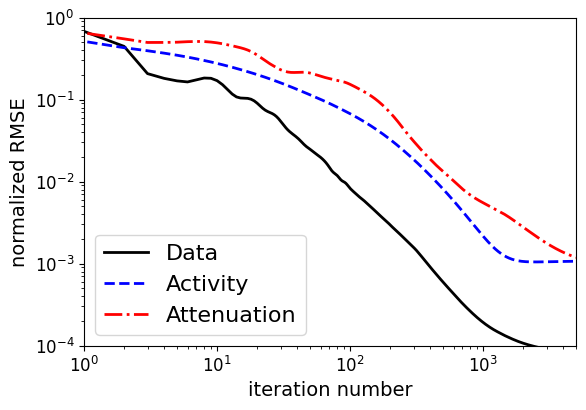

In [9]:
figure(1,figsize=(6,4))
d1 = np.load("./results/saa_bothTV_datarmse.npy")
d2 = np.load("./results/saa_bothTV_imagelrmse.npy")
d3 = np.load("./results/saa_bothTV_imagemrmse.npy")

loglog(d1,"k-",linewidth=2.0,label="Data")
loglog(d2,"b--",linewidth=2.0,label="Activity")
loglog(d3,"r-.",linewidth=2.0,label="Attenuation")
xlabel("iteration number",fontsize=14)
ylabel("normalized RMSE",fontsize=14)
xticks(fontsize=12)
yticks(fontsize=12)
axis([1,5000,0.0001,1])

legend(loc="lower left",fontsize=16)
subplots_adjust(left=0.15,bottom=0.15,top=0.97,right=0.97)

Now we plot the normalized attenuation RMSE versus iterations and reproduce Figure 7.

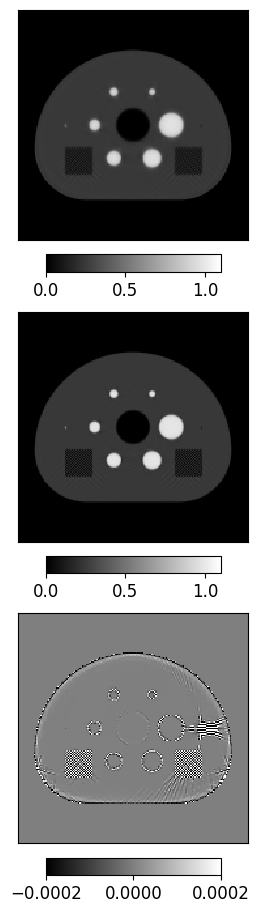

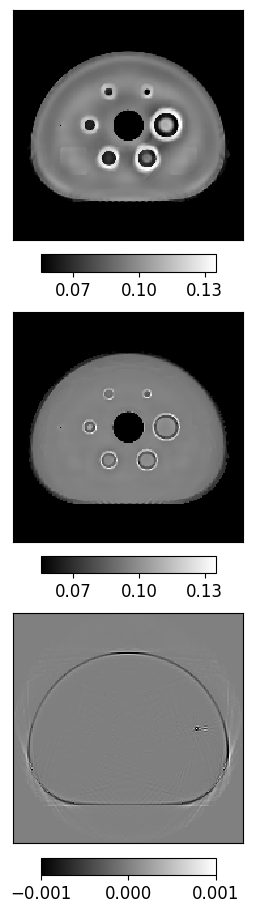

In [22]:
filename = "./results/saa_bothTV_"
lam1 = np.load(filename+"lambda_20.npy")/32768.
mu1 = np.load(filename+"mu_20.npy")
lam2 = np.load(filename+"lambda_50.npy")/32768.
mu2 = np.load(filename+"mu_50.npy")
lam3 = np.load(filename+"lambda_100.npy")/32768.
mu3 = np.load(filename+"mu_100.npy")
lam4 = np.load(filename+"lambda_5000.npy")/32768.
mu4 = np.load(filename+"mu_5000.npy")


vmm1= 0.0
vmx1= 1.1
vmm2= 0.055
vmx2= 0.135
figure(1,figsize=(2.5,9.0))
subplot(311)
imshow(lam2,vmin = vmm1, vmax = vmx1, cmap = cm.gray, interpolation = "nearest")
cb = colorbar(location="bottom",pad = 0.05, shrink=0.70,aspect=10)
cb.set_ticks([0.0,0.5,1.])
cb.ax.tick_params(labelsize='12')
xticks([])
yticks([])
subplot(312)
imshow(lam3,vmin = vmm1, vmax = vmx1, cmap = cm.gray, interpolation = "nearest")
cb = colorbar(location="bottom",pad = 0.05, shrink=0.70,aspect=10)
cb.set_ticks([0.0,0.5,1.])
cb.ax.tick_params(labelsize='12')
xticks([])
yticks([])
subplot(313)
imshow(lam4-testlambda,vmin = -0.0002, vmax = 0.0002, cmap = cm.gray, interpolation = "nearest")
cb= colorbar(location="bottom",pad = 0.05, shrink=0.70,aspect=10)
cb.set_ticks([-2.e-4,0,2.e-4])
cb.ax.tick_params(labelsize='12')
xticks([])
yticks([])
subplots_adjust(left = 0, bottom = 0.01,top = 1,right= 1.0,hspace =0.05)
savefig("figs/lam_noiseless.png")
figure(2,figsize=(2.5,9.0))
subplot(311)
imshow(mu2,vmin = vmm2, vmax = vmx2, cmap = cm.gray, interpolation = "nearest")
cb = colorbar(location="bottom",pad = 0.05, shrink=0.70,aspect=10)
cb.set_ticks([0.07,0.1,0.13])
cb.ax.tick_params(labelsize='12')
xticks([])
yticks([])
subplot(312)
imshow(mu3,vmin = vmm2, vmax = vmx2, cmap = cm.gray, interpolation = "nearest")
cb = colorbar(location="bottom",pad = 0.05, shrink=0.70,aspect=10)
cb.set_ticks([0.07,0.1,0.13])
cb.ax.tick_params(labelsize='12')
xticks([])
yticks([])
subplot(313)
imshow(mu4-testmu,vmin = -0.001, vmax = 0.001, cmap = cm.gray, interpolation = "nearest")
cb= colorbar(location="bottom",pad = 0.05, shrink=0.70,aspect=10)
cb.set_ticks([-0.001,0,0.001])
cb.ax.tick_params(labelsize='12')
xticks([])
yticks([])

subplots_adjust(left = 0, bottom = 0.01,top = 1,right= 1.0,hspace =0.05)


In [23]:
# output directory
resultsfile = './results/saa_interior_bothTV_'

testlambda *= lambdamask   #shrink activity support

sinoatt = sinogram.copy()
sinoatt.fill(0.)
circularParallelBeamProjection(testmu,sinoatt)
attfactor = exp(-sinoatt)
tofsino = zeros([ntof,nviews,nbins])
TOFprojection(testlambda,tofsino)
truess = tofsino.sum(axis=0)
tofdata = attfactor*tofsino
datafactor = totalcounts/tofdata.sum() #scale the data to the desired count level

tofdata *= datafactor
tofsino *= datafactor
testlambda  *= datafactor
truess *= datafactor
ltotalcounts = testlambda.sum()

# normalize again (need to do it this way to allow control over noise)
newfactor = (fovmask.sum()/tofdata.sum())
tofdata *= newfactor
tofsino *= newfactor
testlambda  *= newfactor
truess *= newfactor
ltotalcounts *= newfactor


ptvmu = 100
tgx,tgy = gradim(testmu)
tvmu = numu*sqrt(tgx**2 + tgy**2).sum() *(1.*ptvmu/100.0)

ptvlam = 100
tgx,tgy = gradim(testlambda)
tvlambda = nulam*sqrt(tgx**2 + tgy**2).sum() *(1.*ptvlam/100.0)
print("TVs: ",tvmu,tvlambda)
tvstring = ""
if tvmuswitch:
   tvstring = tvstring + "_TVmu"+str(ptvmu)
if tvlamswitch:
   tvstring = tvstring + "_TVlam"+str(ptvlam)


# grid search results 9cm
# Both TV constraints
if tvmuswitch and tvlamswitch:
   sbmu = 0.2
   sblambda = 4.0
else:
   print("Didn't optimize stepsizes")
   input("stop")

print("sbmu: ",sbmu," sblambda",sblambda)

sigmu = sbmu/lproj
taumu = 1.0/(sbmu*lproj)

siglambda = sblambda/ltofproj
taulambda = 1.0/(sblambda*ltofproj)
print("sblambda: ",sblambda," sbmu: ",sbmu)

worktofsino = 0.*tofsino
ulambda = 0.*tofsino
ylambda = 0.*tofsino

imlambda = testlambda*0.
wimlambda = testlambda*0.
ugradlamx = testlambda*0.
ygradlamx = testlambda*0.
ugradlamy = testlambda*0.
ygradlamy = testlambda*0.

worksino = 0.*sinoatt
umu = 0.*sinoatt
ymu = 0.*sinoatt
ugradmux = testlambda*0.
ygradmux = testlambda*0.
ugradmuy = testlambda*0.
ygradmuy = testlambda*0.

immu = testmu*0.
wimmu = testmu*0.

niter = 5001

newtiter = 10
nuv = 100

datarmses = []
imagelrmses = []
imagemrmses = []
attrmses = []
atttv = []
acttv = []
storeiterations=[1,2,5,10,20,50,100,200,500,1000,2000,5000]

for j in range(niter):
# x-update
   TOFprojection(imlambda,worktofsino)
   arg1 = ulambda+siglambda*(worktofsino -ylambda)
   TOFbackProjection(arg1,wimlambda)
   tgx,tgy = gradim(imlambda)
   tgx *= nulam
   tgy *= nulam

   argx = ugradlamx + siglambda*(tgx - ygradlamx)
   argy = ugradlamy + siglambda*(tgy - ygradlamy)
   wgradimlam = mdiv(argx,argy)
   wgradimlam *= nulam*fovmask
   tvlamest  = sqrt(tgx**2 + tgy**2).sum()

   tempvex =(imlambda -taulambda*(wimlambda +wgradimlam )).flatten()
   tempvex2 = tempvex[flatmask>0.5]
   resvex = euclidean_proj_simplex(tempvex2, s=ltotalcounts)
   tempvex[flatmask>0.5] = resvex*1.
   tempvex.shape = nx,ny
   imlambda = tempvex*1.


   TOFprojection(imlambda,worktofsino)
   workgradlamx, workgradlamy = gradim(imlambda)
   workgradlamx *= nulam
   workgradlamy *= nulam


   circularParallelBeamProjection(immu,worksino)
   arg1 = umu +sigmu*( worksino -ymu )
   circularParallelBeamBackProjection(arg1,wimmu)
   tgx,tgy = gradim(immu)
   tgx *= numu
   tgy *= numu
   argx = ugradmux + sigmu*(tgx - ygradmux)
   argy = ugradmuy + sigmu*(tgy - ygradmuy)
   wgradimmu = mdiv(argx,argy)
   wgradimmu *= numu*fovmask
   immu =immu - wimmu*taumu - wgradimmu*taumu
   immu[immu<0.]=0.
   immu *= mumask


   circularParallelBeamProjection(immu,worksino)
   workgradmux, workgradmuy = gradim(immu)
   workgradmux *= numu
   workgradmuy *= numu

   tvmuest  = sqrt(tgx**2 + tgy**2).sum()
   print("TV lam: ",tvlamest,":",tvlambda," TV mu: ",tvmuest,":",tvmu)
   acttv.append(tvlamest/tvlambda)
   atttv.append(tvmuest/tvmu)

   ylambdat = 1.*ylambda
   ymut = 1.*ymu
# y-update
   aq = siglambda
   cq = -tofdata
   hessmin = 1.e10
   for k in range(nuv):
      ymuterm = ones([ntof])[:,newaxis,newaxis]*exp(-ymu)
      bq = ymuterm - ulambda - siglambda*worktofsino
      ylambdaold = ylambda*1.
      ylambda = (-bq + sqrt(bq*bq - 4.*aq*cq))/(2.*aq)
      ylambdaold = ylambda*1.

      ymunewt = ymu*0.
      for i in range(newtiter):
         grad = (-exp(-ymunewt)*ylambdaold + tofdata).sum(axis=0) - umu + sigmu*(ymunewt - worksino)
         ymuterm = ylambdaold*exp(-ymunewt)
         hess = ymuterm.sum(axis=0) + sigmu
         hessmin = minimum(hessmin,hess.min())
         ymunewt = ymunewt - grad/hess
         ymunewt[ymunewt<0.] = 0.
      ymuold = ymu*1.
      ymu = ymunewt*1.
      ylambdadist = sqrt( ( (ylambda-ylambdaold)**2).sum())
      ymudist = sqrt( ( (ymu-ymuold)**2).sum())



   ptilx= ugradlamx/siglambda + workgradlamx
   ptily= ugradlamy/siglambda + workgradlamy
   ptilmag = sqrt(ptilx**2 + ptily**2)
   tempvex=(ptilmag).flatten()*1.
   if tvlamswitch:
      resvex = euclidean_proj_l1ball(tempvex, s=tvlambda)
   else:
      resvex = tempvex*1.
   resvex.shape = nx,ny
   ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ygradlamx = ptilx*1.
   ygradlamy = ptily*1.

   ptilx= ugradmux/sigmu + workgradmux
   ptily= ugradmuy/sigmu + workgradmuy
   ptilmag = sqrt(ptilx**2 + ptily**2)
   tempvex=(ptilmag).flatten()*1.
   if tvmuswitch:
      resvex = euclidean_proj_l1ball(tempvex, s=tvmu)
   else:
      resvex = tempvex*1.
   resvex.shape = nx,ny
   ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ygradmux = ptilx*1.
   ygradmuy = ptily*1.

   
# u-update
   TOFprojection(imlambda,worktofsino)
   ulambda = ulambda + siglambda*(worktofsino - ylambda)
   tgx,tgy = gradim(imlambda)
   tgx *= nulam
   tgy *= nulam
   ugradlamx = ugradlamx + siglambda*(tgx - ygradlamx)
   ugradlamy = ugradlamy + siglambda*(tgy - ygradlamy)

   circularParallelBeamProjection(immu,worksino)
   umu = umu +sigmu*(worksino-ymu)
   tgx,tgy = gradim(immu)
   tgx *= numu
   tgy *= numu
   ugradmux = ugradmux + sigmu*(tgx - ygradmux)
   ugradmuy = ugradmuy + sigmu*(tgy - ygradmuy)


   attfactorest = exp(-worksino)
   datarmse = sqrt(( (tofdata-worktofsino*attfactorest)**2. ).sum())/sqrt( (tofdata**2).sum() )
   datarmse2 = sqrt(( (tofdata-worktofsino*exp(-worksino))**2. ).sum())/sqrt(1.*ntof*nviews*nbins)
   imagelrmse = sqrt(( (testlambda-imlambda)**2. ).sum())/sqrt( (testlambda**2.).sum() )
   imagemrmse = sqrt(( (testmu-immu)**2. ).sum())/sqrt( (testmu**2.).sum() )
   attdiff = (truess)*(attfactor -  attfactorest)
   attrmse = sqrt(( attdiff**2. ).sum())/sqrt( ((truess*attfactor)**2).sum() )
   datarmses.append(datarmse)
   imagelrmses.append(imagelrmse)
   imagemrmses.append(imagemrmse)
   attrmses.append(attrmse)
   print("iter: ",j," ",datarmse2," ",imagelrmse," ",imagemrmse," ",attrmse)
#   input("step")

   if j+1 in storeiterations:
#save the images with datafactor removed in order to be able to compare with phantom
      save(resultsfile+"lambda_"+str(j+1)+tvstring+".npy",imlambda/(datafactor*newfactor))
      save(resultsfile+"mu_"+str(j+1)+tvstring+".npy",immu)

save(resultsfile+"tvmu"+tvstring+".npy",array(atttv))
save(resultsfile+"tvlambda"+tvstring+".npy",array(acttv))
save(resultsfile+"datarmse"+tvstring+".npy",array(datarmses))
save(resultsfile+"imagelrmse"+tvstring+".npy",array(imagelrmses))
save(resultsfile+"imagemrmse"+tvstring+".npy",array(imagemrmses))
save(resultsfile+"attrmse"+tvstring+".npy",array(attrmses))


TVs:  668.2413518900037 1672.7625239334766
sbmu:  0.2  sblambda 4.0
sblambda:  4.0  sbmu:  0.2
TV lam:  0.0 : 1672.7625239334766  TV mu:  0.0 : 668.2413518900037
iter:  0   0.4037652040538782   0.9405137634137261   1.0   6.973679433958653
TV lam:  231.7273513977727 : 1672.7625239334766  TV mu:  0.0 : 668.2413518900037
iter:  1   0.1392017203541203   0.7824040181694586   0.6118544460743277   1.4809849217089317
TV lam:  824.855394909549 : 1672.7625239334766  TV mu:  614.9522693119554 : 668.2413518900037
iter:  2   0.08927127579263017   0.658706647613202   0.5648035793348274   0.42714734976063645
TV lam:  1032.5313495035275 : 1672.7625239334766  TV mu:  1440.261453000673 : 668.2413518900037
iter:  3   0.11904798039708155   0.6421885965727888   1.274745790837641   0.857854151323785
TV lam:  576.6055606435227 : 1672.7625239334766  TV mu:  2165.380554119816 : 668.2413518900037
iter:  4   0.10866774570455126   0.6211155099063126   1.8625952966704489   0.7356973822127207
TV lam:  746.858538691

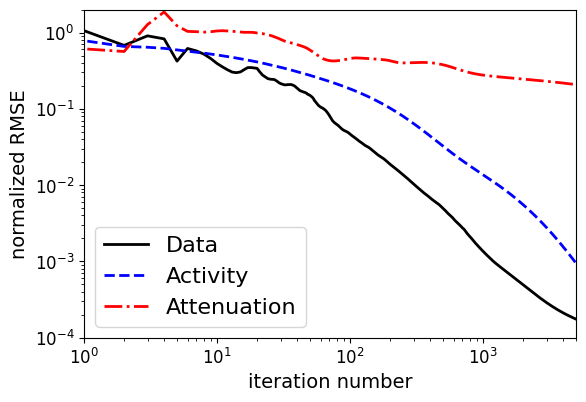

In [32]:
figure(1,figsize=(6,4))
d1 = np.load("./results/saa_interior_bothTV_datarmse_TVmu100_TVlam100.npy")
d2 = np.load("./results/saa_interior_bothTV_imagelrmse_TVmu100_TVlam100.npy")
d3 = np.load("./results/saa_interior_bothTV_imagemrmse_TVmu100_TVlam100.npy")

loglog(d1,"k-",linewidth=2.0,label="Data")
loglog(d2,"b--",linewidth=2.0,label="Activity")
loglog(d3,"r-.",linewidth=2.0,label="Attenuation")
xlabel("iteration number",fontsize=14)
ylabel("normalized RMSE",fontsize=14)
xticks(fontsize=12)
yticks(fontsize=12)
axis([1,5000,0.0001,2])

legend(loc="lower left",fontsize=16)
subplots_adjust(left=0.15,bottom=0.15,top=0.97,right=0.97)

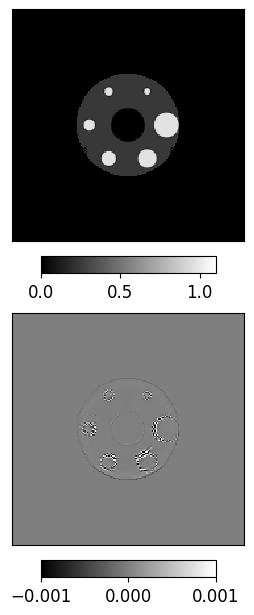

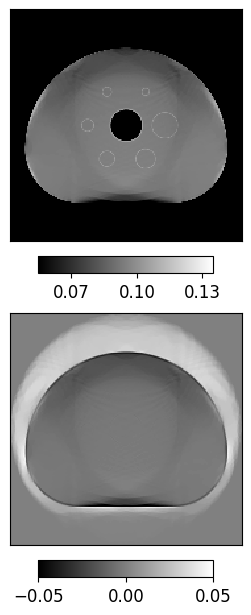

In [52]:
filename = "./results/saa_interior_bothTV_"
lam1 = np.load(filename+"lambda_5000_TVmu100_TVlam100.npy")
mu1 = np.load(filename+"mu_5000_TVmu100_TVlam100.npy")


vmm1= 0.0
vmx1= 1.1
vmm2= 0.055
vmx2= 0.135
figure(1,figsize=(2.5,6.0))
subplot(211)
imshow(lam1, vmin= vmm1, vmax = vmx1, cmap = cm.gray, interpolation = "nearest")
cb = colorbar(location="bottom",pad = 0.05, shrink=0.70,aspect=10)
cb.set_ticks([0.0,0.5,1.])
cb.ax.tick_params(labelsize='12')
xticks([])
yticks([])
subplot(212)
imshow(lam1-testlambda,vmin = -0.001, vmax = 0.001, cmap = cm.gray, interpolation = "nearest")
cb= colorbar(location="bottom",pad = 0.05, shrink=0.70,aspect=10)
cb.set_ticks([-1.e-3,0,1.e-3])
cb.ax.tick_params(labelsize='12')
xticks([])
yticks([])
subplots_adjust(left = 0, bottom = 0.01,top = 1,right= 1.0,hspace =0.05)
figure(2,figsize=(2.5,6.0))
subplot(211)
imshow(mu1,vmin = vmm2, vmax = vmx2, cmap = cm.gray, interpolation = "nearest")
cb = colorbar(location="bottom",pad = 0.05, shrink=0.70,aspect=10)
cb.set_ticks([0.07,0.1,0.13])
cb.ax.tick_params(labelsize='12')
xticks([])
yticks([])
subplot(212)
imshow(mu1-testmu,vmin = -0.05, vmax = 0.05, cmap = cm.gray, interpolation = "nearest")
cb= colorbar(location="bottom",pad = 0.05, shrink=0.70,aspect=10)
cb.set_ticks([-0.05,0,0.05])
cb.ax.tick_params(labelsize='12')
xticks([])
yticks([])
subplots_adjust(left = 0, bottom = 0.01,top = 1,right= 1.0,hspace =0.05)
